# British Airways Forage Data Science Internship Project
## Task 1

Scrape and analyse customer review data to uncover findings for British Airways.
Using the review website SkyTrax (https://www.airlinequality.com/) we can focus on just British Airways at (https://www.airlinequality.com/airline-reviews/british-airways/). 

## 1 Initialization 
First, we shall import all of the modules we will be using

In [19]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from textblob import TextBlob
from wordcloud import WordCloud
from string import digits
import numpy as np
import threading
import requests
import pandas as pd
import nltk
import string
import seaborn as sns
import re
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/trebor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2 Scraping the website
Navigating the SkyTrax website's HTML shows that the reviews are stored under ```text_content```. We then use threads to scrape the first 300 pages of reviews. Threads can be run simultaneously and thus improve the efficiency of data collection. The data collected is saved as the 'review' and the corresponding 'date'. We also ensure that the script can handle any HTML errors.

The data is then saved in a .txt file for ease of use.

In [25]:
# Define the base URL and the number of pages to scrape
base_url = "https://www.airlinequality.com/airline-reviews/british-airways/page/"
total_pages = 300
with open("british_airways_reviews.txt", "w", encoding="utf-8") as file:
    file.write("") #Overwrite any previously saved data    
# Function to scrape a single page and add reviews to the database
def scrape_page(page_num):
    url = f"{base_url}{page_num}/"
    response = requests.get(url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        reviews = soup.find_all(class_="text_content")
        date_element = soup.find_all('time', itemprop='datePublished')
        with open(f"british_airways_reviews.txt", "a", encoding="utf-8") as file:
            for i in range(len(reviews)):
                review_text = reviews[i].get_text(strip=True)
                date = date_element[i]['datetime']
                file.write(review_text + "\t" + date + "\n")
        
        #print(f"Scraping page {page_num} successful.")
    else:
        print(f"Failed to scrape page {page_num}.")

# Define the number of threads to use
num_threads = 4  # You can adjust this number based on your system's capabilities

# Create a list to hold thread objects
threads = []

# Start scraping using multiple threads
for page_num in range(1, total_pages + 1):
    # Create a new thread for each page
    thread = threading.Thread(target=scrape_page, args=(page_num,))
    threads.append(thread)
    thread.start()

# Wait for all threads to finish
for thread in threads:
    thread.join()


## 3 Cleaning and investigation of data
In this section, we will explore the data a bit more and see how we can clean it, make sure it is useful, and think of what we can do with it.

We start by reading the data file in as a Pandas dataframe and outputting the first 5 entries. This allows us to see where we need to tidy up the data.

In [26]:
df = pd.read_csv(f"british_airways_reviews.txt",sep='\t',names=['Review', 'Date'])
df.head()

,Review,Date
0,✅Trip Verified| I paid $1189 for a round trip...,2021-12-30
1,✅Trip Verified| Very nice return flight with B...,2021-12-29
2,"✅Trip Verified| Overall, a very lovely flight...",2021-12-28
3,Not Verified| First of this was one of the sm...,2021-12-27
4,✅Trip Verified| Flying during covid is always...,2021-12-27


We can then use the describe function to see more information about the dataframe.

In [27]:
df.describe()

,Review,Date
count,3031,3000
unique,3007,1713
top,✅Verified Review|,2015-12-01
freq,11,9


Cleaning

In [28]:
df['Verified'] = df['Review'].apply(lambda x: x.split('|')[0])
df['Review'] = df['Review'].apply(lambda x: x.split('|', 1)[1].strip() if '|' in x else x)


In [29]:
unique_entries_counts = df['Verified'].value_counts()

for entry, count in unique_entries_counts.items():
    print(f"{entry}: {count} occurrences")

✅Trip Verified: 1199 occurrences
✅Verified Review: 770 occurrences
Not Verified: 245 occurrences
❎Unverified: 20 occurrences
❎Not Verified: 5 occurrences
British Airways from Tampa to Gatwick on Boeing 777 Club World. Having travelled out WT Plus to Miami we got a good deal coming back from Tampa so flew Club Class. Checked in at Tampa with no queues, and used the International Lounge at Tampa. Supposed to be exclusive to BA customers this had comfortable seats, and good choice of newspapers and magazines. Did not try WiFi. However, there was disappointingly very poor choice of snacks - a few dried up sorry looking sandwiches which were not replenished during my time there, and crackers with some processed cheese with a few dips, some wine, beer, liquor and soft drinks. Pretty uninspiring stuff. On board comfortable, if narrow, seats that extended into (more or less) flat beds. British Airways still have the very camped 2-4-2 layout with fellow passengers having to clamber over people 

In [30]:
verified_reviews = ['✅Trip Verified', '✅Verified Review']
unverified_reviews = ['Not Verified', '❎Unverified', '❎Not Verified']
df['Review'] = df['Review'].str.strip()
df['Review'] = df['Review'].str.lower()
df = df[df['Verified'].isin(verified_reviews + unverified_reviews)]
df.head()


,Review,Date,Verified
0,i paid $1189 for a round trip flight to london...,2021-12-30,✅Trip Verified
1,very nice return flight with ba. to add to my ...,2021-12-29,✅Trip Verified
2,"overall, a very lovely flight with ba to edinb...",2021-12-28,✅Trip Verified
3,first of this was one of the smoothest uk to u...,2021-12-27,Not Verified
4,flying during covid is always a challenge. ba’...,2021-12-27,✅Trip Verified


In [31]:
df['Review'] = df.apply(lambda row: nltk.word_tokenize(row['Review']), axis=1)
df['Review'] = df['Review'].apply(lambda x: ' '.join([word for word in x if word not in (stop_words)]))
df.head()


,Review,Date,Verified
0,paid $ 1189 round trip flight london back prem...,2021-12-30,✅Trip Verified
1,"nice return flight ba . add previous review , ...",2021-12-29,✅Trip Verified
2,"overall , lovely flight ba edinburgh christmas...",2021-12-28,✅Trip Verified
3,first one smoothest uk us flights taken . boar...,2021-12-27,Not Verified
4,flying covid always challenge . ba ’ verifly a...,2021-12-27,✅Trip Verified


In [32]:
def seniment_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None
    
def tag_cal(num):
    if num<-0.05:
        return 'Negative'
    elif num>0.05:
        return 'Positive'
    else:
        return 'Neutral'
        
    
df['Sentiment'] = df['Review'].apply(seniment_calc)


df['Tag'] = df['Sentiment'].apply(tag_cal)
df.head()

,Review,Date,Verified,Sentiment,Tag
0,paid $ 1189 round trip flight london back prem...,2021-12-30,✅Trip Verified,-0.009896,Neutral
1,"nice return flight ba . add previous review , ...",2021-12-29,✅Trip Verified,0.381439,Positive
2,"overall , lovely flight ba edinburgh christmas...",2021-12-28,✅Trip Verified,0.212897,Positive
3,first one smoothest uk us flights taken . boar...,2021-12-27,Not Verified,-0.030000,Neutral
4,flying covid always challenge . ba ’ verifly a...,2021-12-27,✅Trip Verified,0.273220,Positive


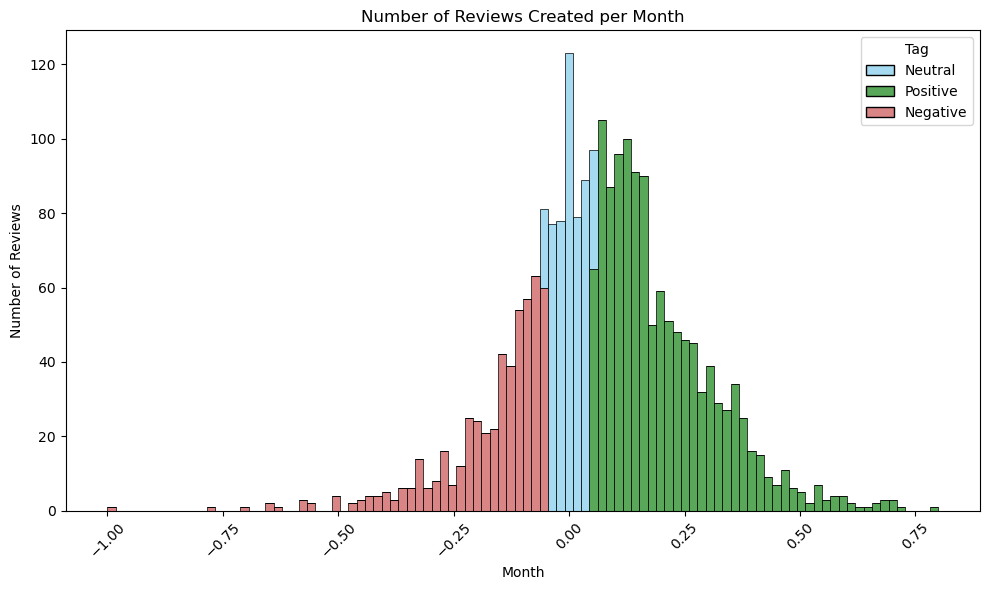

<Figure size 640x480 with 0 Axes>

In [33]:
plt.figure(figsize=(10, 6))

plot_ = sns.histplot(data=df, x='Sentiment', hue = 'Tag', multiple = "stack", bins=100, kde=False,palette={'Negative': 'indianred', 'Neutral': 'skyblue', 'Positive': 'forestgreen'} )

plt.xticks(rotation=45)
        
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Created per Month')
plt.tight_layout()

# Show the histogram
plt.show()
plt.savefig("NumReview.png", dpi=200)

In [34]:
df['Verified'] = df['Verified'].apply(lambda x: 1 if x in verified_reviews else 0)
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna(axis = 0, how = 'any')
# Extract the month from the 'Date' column
df = df.sort_values('Date')

df.head()

,Review,Date,Verified,Sentiment,Tag
2409,gatwick amsterdam business class truly uncomfo...,2016-03-23,1,-0.023106,Neutral
2407,british airways seattle johannesburg via londo...,2016-03-23,1,0.087634,Positive
2406,"flown british airways 100 times , usually busi...",2016-03-24,1,0.089583,Positive
2405,"london heathrow houston british airways , frie...",2016-03-25,1,0.168056,Positive
2404,istanbul london heathrow british airways . mai...,2016-03-26,1,0.205128,Positive


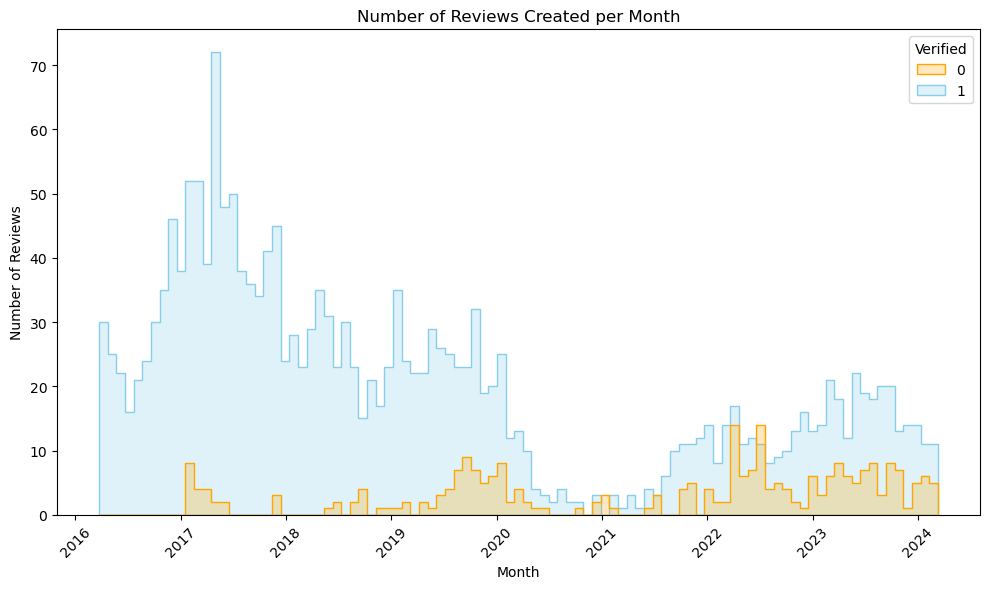

<Figure size 640x480 with 0 Axes>

In [35]:
plt.figure(figsize=(10, 6))
earliest_date = df['Date'].min()
latest_date = df['Date'].max()
# Calculate the range in months
months_range = (latest_date - earliest_date) // pd.Timedelta(days=30)
#plot_ = sns.histplot(data=new_df, x = 'Date', bins = months_range, kde=False, color='skyblue')
plot_ = sns.histplot(data=df, x='Date', hue='Verified', bins=months_range, kde=False, element="step", stat="count", common_norm=False, palette={0: 'orange', 1: 'skyblue'})

plt.xticks(rotation=45)
        
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Created per Month')
plt.tight_layout()

# Show the histogram
plt.show()
plt.savefig("NumReview.png", dpi=200)

Now focusing on the verfified reviews.

In [36]:
df = df[df['Verified']==1]

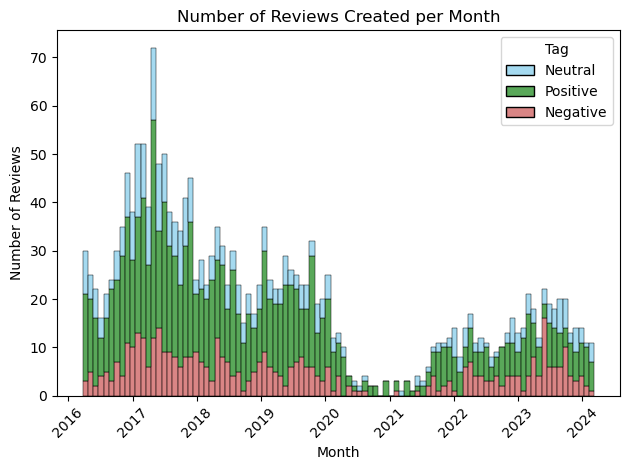

<Figure size 640x480 with 0 Axes>

In [37]:

plot_ = sns.histplot(data=df, x='Date', hue='Tag', multiple="stack", bins=months_range, kde=False, palette={'Negative': 'indianred', 'Neutral': 'skyblue', 'Positive': 'forestgreen'})
plt.xticks(rotation=45)
        
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Created per Month')
plt.tight_layout()

# Show the histogram
plt.show()
plt.savefig("NumReview.png", dpi=200)

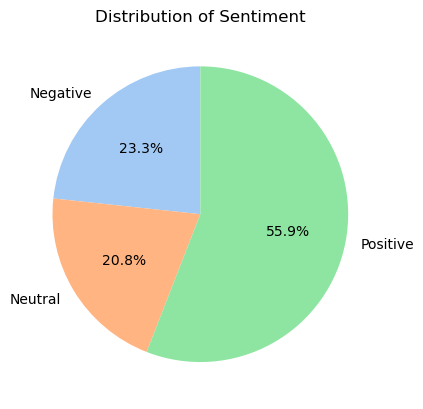

In [42]:
sentiment_percent = (df.groupby('Tag').size()/df['Tag'].count())*100
sns.set_palette("pastel")  # Optional: Set color palette
plt.pie(sentiment_percent, labels=sentiment_percent.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sentiment')

# Show the pie chart
plt.show()

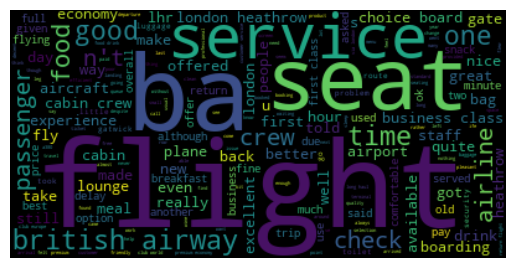

In [39]:
text = " "
for ind in df.index:
    if df['Tag'][ind] == "Positive":
        text = text + df['Review'][ind]
      
wordcloud_positive = WordCloud().generate(text)


# Display the generated image:
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.show()

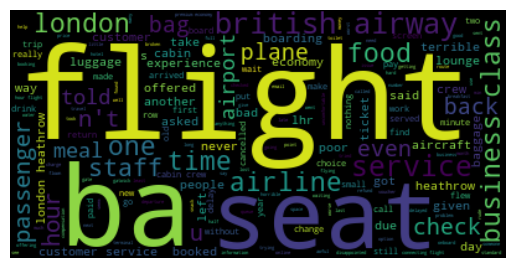

In [40]:
text2= " "        
for ind in df.index:
    if df['Tag'][ind] == "Negative":
        text2 = text2 + df['Review'][ind]  
wordcloud_negative = WordCloud().generate(text2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.show()